In [1]:
# Author Bereket Kebede, Graduate Student
# Neural Networks -  Assignment 5 - University of Memphis. Fall 2021
# Question #1, AutoEncoder for Denoising
# Last updated - Nov 25, 2021


In [2]:
#####################################################################################
# Import necessary libraries

import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose, Input,  BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

In [25]:
#####################################################################################
# Pre-processing data

path = 'C:/Users/CIRL/Desktop/Bereket/Neural Networks/Assignment 5/document_denoising_dataset'

# store image names in list for later use
train_img = sorted(os.listdir(path + '/train/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned/train_cleaned'))
test_img = sorted(os.listdir(path + '/test/test'))
test_cleaned_img = sorted(os.listdir(path + '/test_cleaned/test_cleaned'))

# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

# preprocess images
train = []
train_cleaned = []
test = []
test_cleaned = []

for f in sorted(os.listdir(path + '/train/train/')):
    train.append(process_image(path + '/train/train/' + f))

for f in sorted(os.listdir(path + '/train_cleaned/train_cleaned/')):
    train_cleaned.append(process_image(path + '/train_cleaned/train_cleaned/' + f))
   
for f in sorted(os.listdir(path + '/test/test/')):
    test.append(process_image(path + '/test/test/' + f))
    
for f in sorted(os.listdir(path + '/test_cleaned/test_cleaned/')):
    test_cleaned.append(process_image(path + '/test_cleaned/test_cleaned/' + f))
    

# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)
Y_test = np.asarray(test_cleaned)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

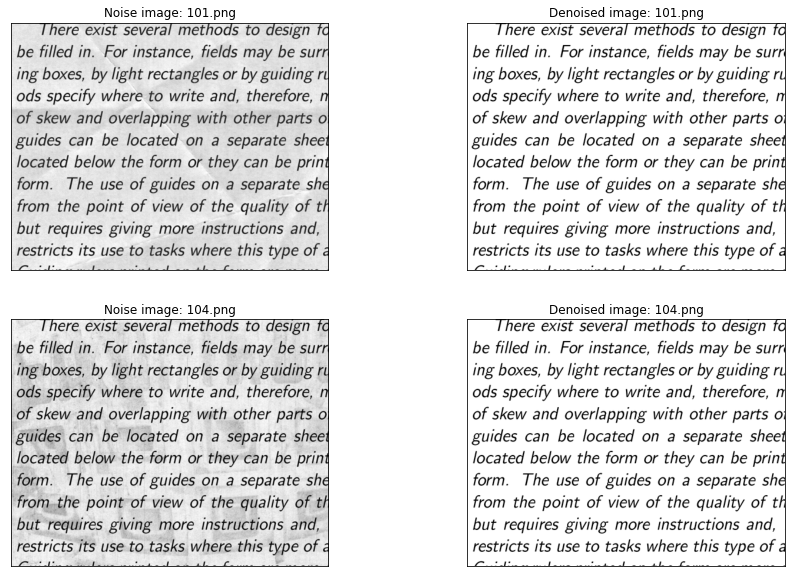

In [4]:
#####################################################################################
# Visualize sample denoised document

plt.figure(figsize=(15,10))

for i in range(0,4,2):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(2,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [5]:
#####################################################################################
# Define auto-encoder model

def model():
    input_layer = Input(shape=(420, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

In [6]:
#####################################################################################
# Train the model

callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=600, batch_size=24, verbose=0, callbacks=[callback])
model.save("denoising document model.h5")

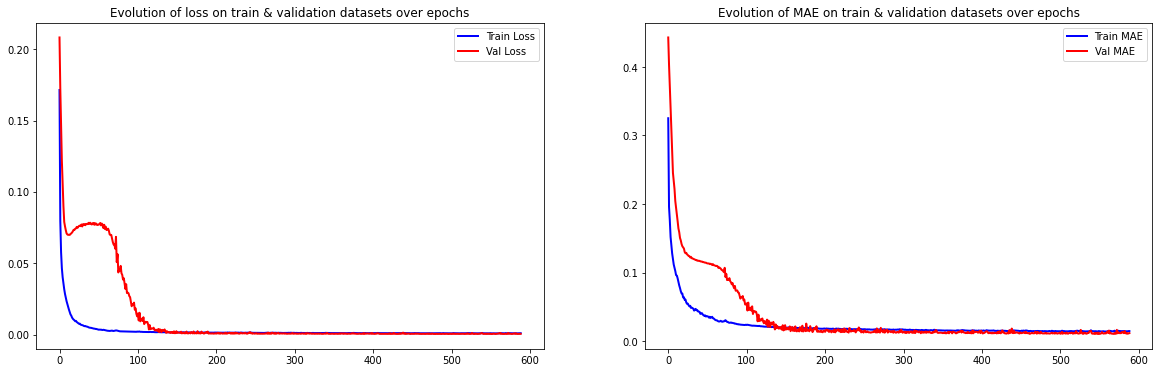

In [7]:
#####################################################################################
# Plot the training loss

# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')


plt.savefig("autoencoder loss image denoising.png")

plt.show()

In [8]:
#####################################################################################
# Predict denoised result

Y_test_pred = model.predict(X_test, batch_size=16)

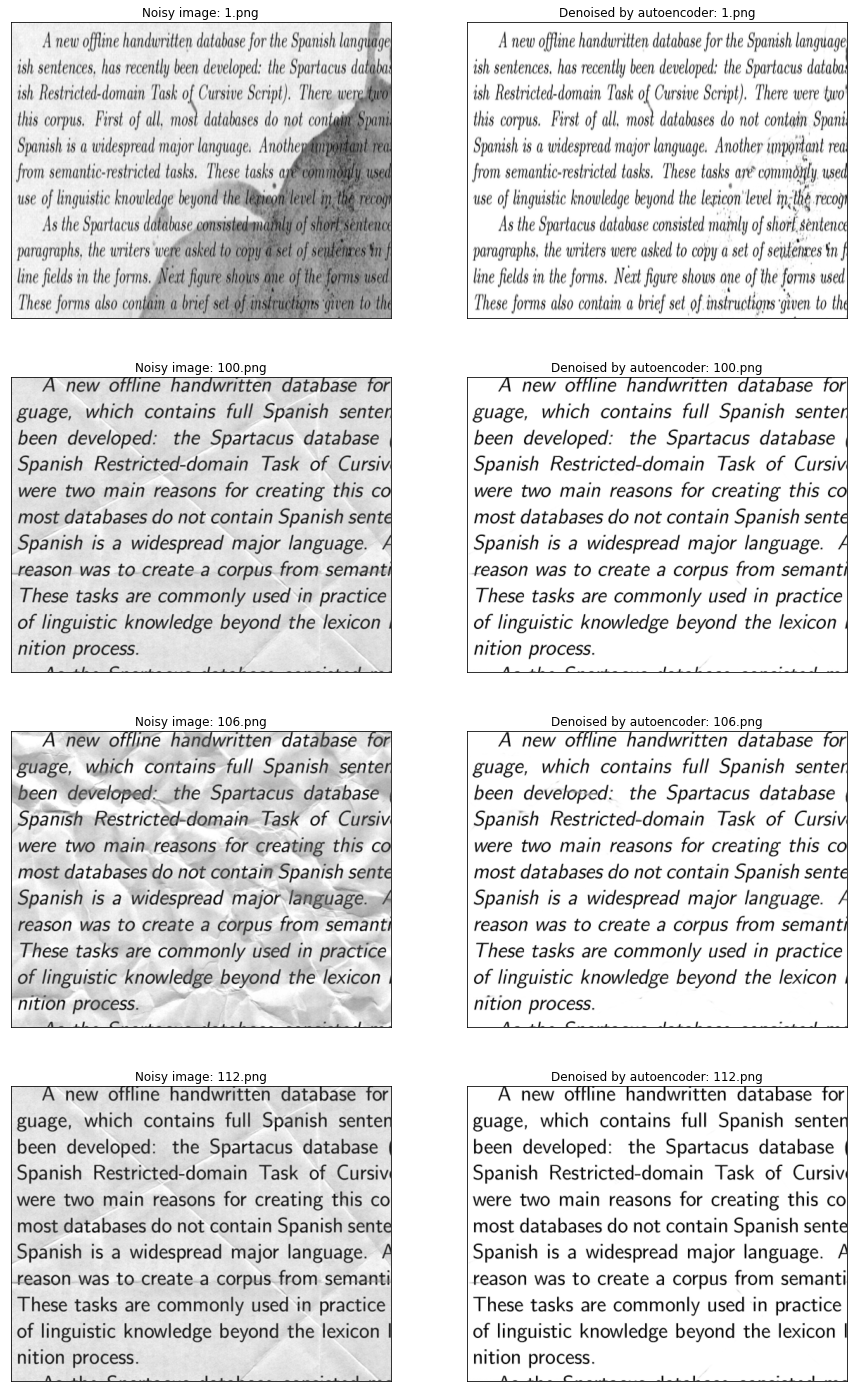

In [10]:
#####################################################################################
# Visualize denoised result by the auto-encoder

plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test_pred[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [30]:
#####################################################################################
# Calculate Mean Square Error(MSE) and SSIM

def mse(imageA, imageB):
    error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    error /= float(imageA.shape[0] * imageA.shape[1])
    return error

from skimage.metrics import structural_similarity as ssim

In [36]:
#####################################################################################
# Calculate Mean Square Error(MSE) and SSIM on sample test result

print("mse: ", mse(test_cleaned[1][:,:,0],  Y_test_pred[1][:,:,0]))

print ("ssim: ", ssim(test_cleaned[1][:,:,0], Y_test_pred[1][:,:,0]))

mse:  0.0005940072631486073
ssim:  0.9935223767301706
